In [260]:
%matplotlib inline
import numpy as n
# The following 2 lines are necessary to make the
# GUI work right, at least for me. YMMV!
from matplotlib import pyplot as p
from matplotlib import cm
from matplotlib.patches import Ellipse
import lensdemo_funcs as ldf
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from cosmocalc import cosmocalc

In [22]:
# Package some image display preferences in a dictionary object, for use below:
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.gray}

In [256]:
# Make some x and y coordinate images:
nx = 501
ny = 501
xhilo = [-2.5, 2.5]
yhilo = [-2.5, 2.5]
x = (xhilo[1] - xhilo[0]) * n.outer(n.ones(ny), n.arange(nx)) / float(nx-1) + xhilo[0]
y = (yhilo[1] - yhilo[0]) * n.outer(n.arange(ny), n.ones(nx)) / float(ny-1) + yhilo[0]

In [272]:
# Set some SIE lens-model parameters and pack them into an array:
l_amp = 1.2  # Einstein radius
l_xcen = 0.0  # x position of center
l_ycen = 0.0  # y position of center
l_min = 0.1 #minor axis size
l_max = 0.6 #major axis size
l_axrat = l_min/l_max # minor-to-major axis ratio
l_pa = 0.0    # major-axis position angle (degrees) c.c.w. from x axis
lpar = n.asarray([l_amp, l_xcen, l_ycen, l_axrat, l_pa])


In [273]:
# Compute the lensing potential gradients:
(xg, yg) = ldf.sie_grad(x, y, lpar)

In [282]:
# Set some Gaussian blob image parameters and pack them into an array:
g_amp = 1.0   # peak brightness value
g_sig = 0.05  # Gaussian "sigma" (i.e., size)
g_xcen = 0  # x position of center
g_ycen = 0  # y position of center
g_axrat = 1 # minor-to-major axis ratio
g_pa = 0.0    # major-axis position angle (degrees) c.c.w. from x axis
gpar = n.asarray([g_amp, g_sig, g_xcen, g_ycen, g_axrat, g_pa])


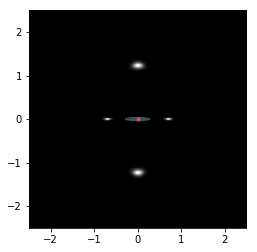

In [283]:
# Evaluate lensed Gaussian image:
g_lensimage = ldf.gauss_2d(x-xg, y-yg, gpar)

# Plot images:
f = p.imshow(g_lensimage, **myargs, extent=[xhilo[0], xhilo[1], yhilo[0], yhilo[1]])
p.scatter(g_xcen, g_ycen, c='r', s=10) #plot source

ax = p.gca() #plot lens
ax.add_patch(Ellipse((l_xcen, l_xcen), width=l_max, height=l_min, angle=l_pa,
                     edgecolor='none',
                     facecolor='skyblue',
                     alpha = 0.4,
                     linewidth=1))

In [284]:
#pick out maxima minima in the image
filtersize = 20
threshold = 0.5

im_max = filters.maximum_filter(g_lensimage, filtersize)
maxima = (g_lensimage == im_max)
im_min = filters.minimum_filter(g_lensimage, filtersize)
diff = ((im_max - im_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
QSOx, QSOy = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    QSOx.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    QSOy.append(y_center)

# convert to image co-ordinates
QSOxt = n.array(QSOx)/nx*(xhilo[1] - xhilo[0]) + xhilo[0]
QSOyt = n.array(QSOy)/ny*(yhilo[1] - yhilo[0]) + yhilo[0]



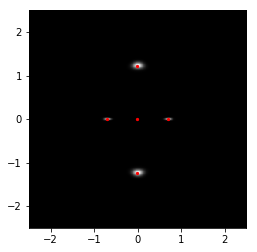

In [285]:
f = p.imshow(g_lensimage, **myargs, extent=[xhilo[0], xhilo[1], yhilo[0], yhilo[1]])
p.scatter(QSOxt, QSOyt, c='r', s=5)


In [286]:
#print QSO image position and surface brightness 
nmax = n.size(QSOxt)
print('images found: ',nmax)
for i in n.arange(nmax):
    print(i+1, '. x: ', QSOxt[i], ', y: ', QSOyt[i], ', I: ', g_lensimage[n.int(QSOy[i]),n.int(QSOx[i])])

images found:  5
1 . x:  -0.004990019960080083 , y:  -1.2325349301397206 , I:  0.9997437098703341
2 . x:  -0.7035928143712575 , y:  -0.004990019960080083 , I:  0.9984882601919863
3 . x:  -0.004990019960080083 , y:  -0.004990019960080083 , I:  1.0
4 . x:  0.6936127744510978 , y:  -0.004990019960080083 , I:  0.9984882601919861
5 . x:  -0.004990019960080083 , y:  1.2225548902195609 , I:  0.9997437098703341


# Magnitudes:
Gaussian 2d surface brightness profile is:  
$ I(r) = \frac{L_{tot}}{q\pi\sigma^2}  \frac{1}{2}  \exp (\frac{1}{2} \frac{r^2}{\sigma^2})$  

where q = axis ratio, sigma = intermediate-axis sigma, r = projected source lens separation  

Note that in the lensdemo_funcs, gauss2d takes and outputs amplitude which is equivalent to the term
$ \frac{L_{tot}}{q*\pi*\sigma^2} \frac{1}{2}$  

Then can convert to magnitudes if needed using  
$M_* - M_\odot = -2.5 \log \frac{L_*}{L_\odot}$


In [287]:
def mag2amp(M, par):
    #returns amplutude value to plug into g_amp if you want in terms of magnitude 
    #M:      abs magnitude
    #par[0]: axis ratio of source, g_axrat
    #par[1]: variance of gaussian source, g_sig
    
    L = 10**(-0.4*M) # luminoisty in units  3.0128×10**28Watts
    amp = L/(2.0 * par[0] * pi * par[1]**2)
    return(amp)

def amp2mag(amp, par):
    #returns amplutude value to plug into g_amp if you want in terms of magnitude 
    #amp:      amplitude
    #par[0]: axis ratio of source, g_axrat
    #par[1]: variance of gaussian source, g_sig
    
    L = amp * (2.0 * par[0] * pi * par[1]**2)
    M = n.log10(L)/(-0.4)
    return(M)

# Einstein radius 
(see kolchanek 2004)   
The einstein radius is needed... this is a function of the lens mass. 

For an SIE, this is  
$ l_{amp} = 4 \pi \left( \frac{\sigma_v}{c}\right)^2 \frac{D_{ls}}{D_s} (\frac{e_3}{ asin(e_3)})$

where  
$e_3 = \sqrt{1-q_3^2}$  
$q^2 = q_3^2 cos^2 i + sin^2 i $  
is related to the 3D density of the lens, $q$ is the axis ratio and $i$ the inclination


$\sigma_v$ is the velocity dispersion, where for a sphere would be  
$\sigma_v = \frac{G M}{5 R}$ 

Or we could use some Faber-Jackson relation to get $\sigma_v$ from luminosity? Might be easier given the data we have... 


In [288]:
def mass2amp(M,R, q, i ,zl ,zs, H0, Om, Ol):
    # convert galaxy mass to einstein radius
    # M: Mass in solar mass
    # R: lens radius in Mpc
    # q: axis ratio
    # i: inclination
    # zl: lens redshift
    # zs: source redshift
    # Ho: hubble const
    # Om: omega matter 
    # Ol: omega lambda
    cMpc = 9.715841e-15 #speed of light in Mpc/s
    GG   = 4.515873e-48 #G in Mpc^-3 Msun^-1 s^-2
    #calculate angular diameter distances in Mpc to lens and source
    dL  =   cosmocalc(zl,Ho,Om,Ol)['DA_Mpc']
    dS  =   cosmocalc(zs, Ho,Om, Ol)['DA_Mpc']
    dLS =   (dS*(1.0+zs)-dL*(1.0+zl))/(1.0+zs)
    
    sigma = GG*M/(5*R)
    
    q3 = n.sqrt( (q**2 - n.sin(i)**2) / (n.cos(i)**2))
    e3 = sqrt( 1 - q3**2)
    l_amp = 4*pi*sigma*sigma/cMpc/cMpc*(dLS/dS)*(e3/n.arcsin(e3))
    
    return(l_amp)